#Intro
 Lets try creating a custom enviroment and implenting a policy within that enviroment
 Hmm maybe an easy start would be tic-tac-toe

 Lets start by defining a visualzation for the board!

In [ ]:
!pip install gymnasium

In [ ]:
import numpy as np
import gymnasium as gym
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

from collections import deque


In [ ]:
def display_board(state):
  """
    Displays the game board
  """
  space = np.zeros(9).reshape((3,3))
  print("===========")
  for i in range(3):
    print("|",end="")
    for j in range(3):
      if state[i][j] == 1:
        print(" x ",end="")
      elif state[i][j] == 2:
        print(" o ",end="")
      else:
        print(" _ ",end="")
    print("|")
  print("===========")

In [ ]:
x = np.zeros(9)
x = x.reshape((3,3))
print(x)

state=np.ones(9).reshape(3,3)

print(state)

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]


In [ ]:
display_board(state)

| x  x  x |
| x  x  x |
| x  x  x |


In [ ]:
state= [[1,0,1],[2,2,1],[0,0,0]]

In [ ]:
display_board(state)

| x  _  x |
| o  o  x |
| _  _  _ |


Nice!

# Gymnasuim Env

In [ ]:
def is_over(state):
  for i in range(3):  # 0 indicates cat game, 1 - player 1 and 2 is player 2
    if state[i,0] == state[i,1] == state[i,2] and state[i,0] != 0:
      return True,state[i,0]
    if state[0,i] == state[1,i] == state[2,i] and state[2,i] != 0:
      return True,state[2,i]
    if state[0,0] == state[1,1] == state[2,2] and state[2,2] != 0:
      return True, state[2,2]
    if state[0,2] == state[1,1] == state[2,0] and state[2,0] != 0:
      return True, state[2,0]
  else:
    return False, 0


In [ ]:
def adversary_moves(avail_moves): #adversary makes a random move
  return random.choice(avail_moves)

In [ ]:
def reward_calc_winner(state,info,moves):
  done, winner = is_over(state) # Check if there was a winner

  if not done: # if not check for cats game
    if check_cats(moves):
      reward= 0 #punish a cats game
      done = True
      info["Winner"] = "Cats Game Meow!"
  if done:
    if winner == 2:
      reward = -10 # Punish for losing
      info["Winner"] = "Player 2"
    if winner == 1:
      reward = 50  # Reward for winning
      info["Winner"] = "Policy"
  if not done:
    reward = 1
  return done,reward,info

def check_cats(moves):
  if len(moves) == 0:
    return True


# New

In [ ]:
class tic_tac_toe_env(gym.Env):
  def __init__(self):
    self.observation_space = gym.spaces.MultiDiscrete([3,3,3])
    self.action_space = gym.spaces.MultiDiscrete([3,3])

    self.state = None
    self.total_turns = None
    self.is_turn = None

    self.avail_moves =  None

  def reset(self,seed=None):
    state=np.zeros(9).reshape(3,3)
    self.state = state

    self.avail_moves = [[i, j] for i in range(3) for j in range(3)]  # List of all possible moves
    self.is_move = random.randint(0,1)
    if self.is_move == 0:  # Opponent goes first
        opp_move = adversary_moves(self.avail_moves)  # Opponent makes an initial move
        self.avail_moves.remove(opp_move)
        self.state[opp_move[0]][opp_move[1]] = 2  # Place the 'o' on the board
        self.is_move = 1

    return self.state

  def step(self,action):
    info = {}
    truncated = False
    done = False

    #print(f"Available moves are: {self.avail_moves}")
    if list(action) not in self.avail_moves: # Check if the agents move is valid punish otherwise
      truncated = True
      return self.state,-5,False,True, {"Truncated": "Invalid Moved by Agent"}

    self.state[action[0]][action[1]] = 1
    self.avail_moves.remove(list(action))

    done,reward,info = reward_calc_winner(self.state,info,self.avail_moves) # Check board state

    if done or truncated:
      return self.state, reward, done, truncated, info


    # Opponents turn
    opp_move = adversary_moves(self.avail_moves)
    self.avail_moves.remove(opp_move)
    self.state[opp_move[0]][opp_move[1]] = 2  # Place the 'o' on the board
    done, reward, info = reward_calc_winner(self.state,info, self.avail_moves) # make sure the games still valid

    #print(self.state,reward,done,truncated,info)
    return self.state, reward, done, truncated , info

  def render(self,render_mode="human"):
    display_board(self.state) # Display Board

In [ ]:
env = tic_tac_toe_env()
env.reset()
for i in range(20):
  action = env.action_space.sample()
  state,reward,done,truncated,info = env.step(action)
  print(state,reward,done,truncated,info)
  if truncated or done:
    print(info)
    env.reset()
  env.render()

# Lets create a Policy for our agent now!

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [327]:
class Policy(nn.Module):
  def __init__(self, s_size, a_size, h_size):
    super(Policy, self).__init__()
    self.flatten = nn.Flatten()

    self.relu_stack = nn.Sequential(
        nn.Linear(s_size, h_size),
        nn.ReLU(),
        nn.Linear(h_size,h_size),
        nn.ReLU(),
        nn.Linear(h_size,a_size),
    )

    self.h_size = h_size
    self.a_dims = a_size



  def forward(self,x):
    x = self.flatten(x) # flatten the input
    logits = self.relu_stack(x) # Pass through the stack
    probs = F.softmax(logits,dim=1) # Return a tensor of the probabilities for each action
    return(probs)


  def act(self,state):
    """
    Given a state, sample an action based
    on the probability distribution
    """
    state = torch.from_numpy(state).float().unsqueeze(0).to(device)
    probs = self.forward(state).cpu()
    m    = Categorical(probs) #creates a distrubtion based of the output action probibilities
    action = m.sample() # select a random action based on the probabilites distribution
    return action.item(), m.log_prob(action) # return the action, and the logarthimic probability of taking that action Given the distrubution


# Implementing the policy in pytorch

In [332]:
def calc_action(action): #action 0-8
  row = action // 3
  col = action % 3
  return (row,col)

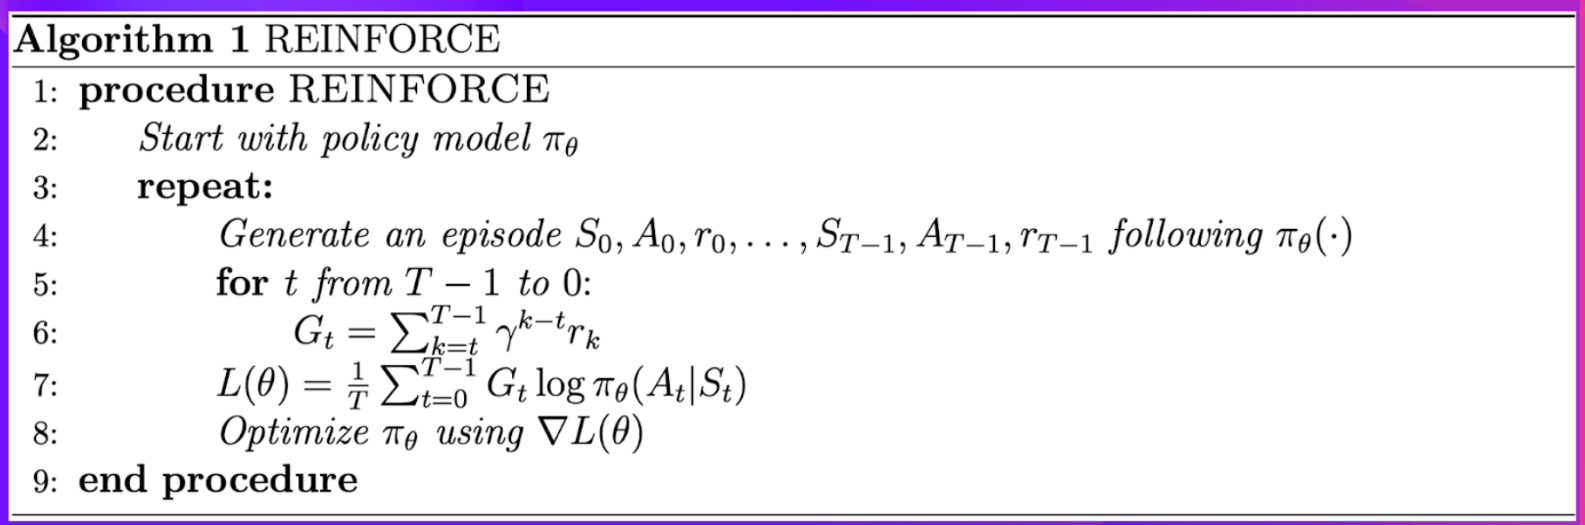

In [341]:
#From https://huggingface.co/learn/deep-rl-course/unit4/hands-on

def reinforce(policy, optimizer, n_training_episodes, max_t, gamma, print_every):
  # Help us to calculate the score during the trianing
  scores_deque = deque(maxlen=100)
  scores = []
  # Line 3 of pseudocode
  for i_episode in range(1,n_training_episodes+1):
    saved_log_probs = []
    rewards = []
    state = env.reset()
      # Line 4 of pseudocode
    for t in range(max_t):
        action, log_prob = policy.act(state)
        action = calc_action(action)
        saved_log_probs.append(log_prob)
        state,reward,done,truncated,_ = env.step(action)
        rewards.append(reward)
        if done or truncated:
            break

    scores_deque.append(sum(rewards))
    scores.append(sum(rewards))

   # Line 5 of pseudocode: calculate the return
    returns = deque(maxlen=max_t)
    n_steps = len(rewards)

    for t in range(n_steps)[::-1]:
      disc_return_t = (returns[0] if len(returns) > 0 else 0)
      returns.appendleft(gamma * disc_return_t + rewards[t])


    # Standardization of the reuturns is employed to make training more stable
    eps = np.finfo(np.float32).eps.item()

    # eps is the smallest representable float, whic is
    # added to the standard deviation of the returns to avoid numerical instabilities

    returns = torch.tensor(returns)
    if len(returns) == 1: #If the actor makes the same move as the opponent on their first move
                          #the game is truncated
      returns = torch.full_like(returns,-1)
    else:
      std = returns.std()
      if std.item() == 0:
        returns = (returns - returns.mean()) / eps
      else:
        returns = (returns - returns.mean()) / (returns.std() + eps)

    invalid_initial_moves = 0

    policy_loss = []
    for log_prob, disc_return in zip(saved_log_probs, returns):
        policy_loss.append(-log_prob*disc_return)
    policy_loss = torch.cat(policy_loss).sum()

    optimizer.zero_grad()
    policy_loss.backward()
    optimizer.step()


    if i_episode % print_every == 0:
      print('Episode {}\tAverage Score: {:.2f}'.format(i_episode,np.mean(scores_deque)))

  return scores



# Training!

In [342]:
env = tic_tac_toe_env()
tic_tac_toe_hyperparameters ={
    "h_size": 64,
    "n_training_episodes": 100000,
    "n_evaluation_episodes": 20,
    "max_t":15,
    "gamma":.99,
    "lr" : .0005,
    "env":env,
    "state_space":9,
    "action_space":9,
}

In [343]:
tic_tac_toe_policy = Policy(
    tic_tac_toe_hyperparameters["state_space"],
    tic_tac_toe_hyperparameters["action_space"],
    tic_tac_toe_hyperparameters["h_size"],
).to(device)

tic_tac_toe_optimizer = optim.Adam(tic_tac_toe_policy.parameters(), lr=tic_tac_toe_hyperparameters["lr"])

In [ ]:
scores = reinforce(
    tic_tac_toe_policy,
    tic_tac_toe_optimizer,
    tic_tac_toe_hyperparameters["n_training_episodes"],
    tic_tac_toe_hyperparameters["max_t"],
    tic_tac_toe_hyperparameters["gamma"],
    1000
)

Episode 1000	Average Score: -2.27
Episode 2000	Average Score: -1.74
Episode 3000	Average Score: -1.59
Episode 4000	Average Score: -1.30
Episode 5000	Average Score: -1.45
Episode 6000	Average Score: -0.99
Episode 7000	Average Score: -1.95
Episode 8000	Average Score: -1.72
Episode 9000	Average Score: -0.63
Episode 10000	Average Score: -0.62
Episode 11000	Average Score: -0.92
Episode 12000	Average Score: -2.23
Episode 13000	Average Score: -1.12


It is really interesting to see how the Actor slowly learns not to make the same initial move as the oppoenent and thus their are less instances of the reward tensor only holding a single value as the training progresses!


# Evaluate Agent

In [322]:
def evaluate_agent(env,max_steps, n_eval_episodes, policy):
  """
  Evluate the agent for ``n_eval_episodes`` episodes and returns average reward and std of reward
  :param env: The evaluation enviroment
  :param n_eval_episodes: Number of episode to evaluate the agent
  :param policy: The Reinforce agent
  """

  episode_rewards = []
  for episode in range(n_eval_episodes):
    state = env.reset()
    step = 0
    done = False
    total_rewards_ep = 0

    for step in range(max_steps):
      action, _ = policy.act(state)
      action = calc_action(action)
      new_state, reward,done,truncated,info = env.step(action)

      total_rewards_ep += reward
      if done or truncated:
        print("GAME OVER")
        print()
        print(info)
        print()
        break
      env.render()
      state = new_state
  episode_rewards.append(total_rewards_ep)
  mean_reward = np.mean(episode_rewards)
  std_reward = np.std(episode_rewards)

  return mean_reward, std_reward

In [323]:
eval_env = tic_tac_toe_env()

In [324]:
mean_reward, std_reward = evaluate_agent(eval_env, tic_tac_toe_hyperparameters["max_t"], 10, tic_tac_toe_policy)

| _  _  x |
| _  o  o |
| _  _  _ |
| o  _  x |
| x  o  o |
| _  _  _ |
| o  o  x |
| x  o  o |
| _  _  x |
GAME OVER

{'Winner': 'Cats Game Meow!'}

| _  _  _ |
| _  x  _ |
| _  _  o |
| x  _  o |
| _  x  _ |
| _  _  o |
| x  o  o |
| _  x  x |
| _  _  o |
GAME OVER

{'Truncated': 'Invalid Moved by Agent'}

| o  x  o |
| _  _  _ |
| _  _  _ |
| o  x  o |
| x  _  _ |
| o  _  _ |
| o  x  o |
| x  x  o |
| o  _  _ |
GAME OVER

{'Winner': 'Cats Game Meow!'}

| _  _  _ |
| o  x  _ |
| _  _  _ |
| o  _  x |
| o  x  _ |
| _  _  _ |
| o  _  x |
| o  x  x |
| _  _  o |
GAME OVER

{'Truncated': 'Invalid Moved by Agent'}

| _  o  _ |
| _  x  _ |
| _  _  _ |
| _  o  x |
| _  x  _ |
| o  _  _ |
| _  o  x |
| _  x  o |
| o  x  _ |
| _  o  x |
| x  x  o |
| o  x  o |
GAME OVER

{'Winner': 'Cats Game Meow!'}

| o  _  _ |
| _  x  _ |
| _  _  _ |
| o  _  _ |
| x  x  _ |
| _  _  o |
| o  _  x |
| x  x  _ |
| o  _  o |
| o  _  x |
| x  x  o |
| o  x  o |
GAME OVER

{'Winner': 'Policy'}

| _  _  _ |
| o  

In [325]:
print(mean_reward,std_reward)

8.0 0.0
